# On-Time Delivery Prediction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import zipfile
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib
from sklearn.preprocessing import LabelEncoder

In [2]:
def load_data(zip_path, file_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extract(file_name)
    data = pd.read_csv(file_name)
    print("Data loaded successfully.")
    return data

# Replace with the actual file name inside the ZIP file
zip_path = 'On-Time Delivery.zip'
file_name = 'Train new.csv'  # Adjust based on actual file
data = load_data(zip_path, file_name)

# Inspect the dataset
print("Dataset Overview:")
print(data.info())
print("\nFirst 5 Rows:")
print(data.head())
print("\nMissing Values Summary:")
print(data.isnull().sum())


Data loaded successfully.
Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None

First 5 Rows:
   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1      

In [3]:
# Data Preprocessing

def preprocess_data(df):
    # Encode categorical variables
    label_encoders = {}
    for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    # Normalize or scale numerical features if needed
    # For simplicity, we'll keep scaling optional
    numerical_features = ['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms']
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # Split features and target
    X = df.drop(columns=['Reached.on.Time_Y.N', 'ID'])  # Drop ID as it's not relevant
    y = df['Reached.on.Time_Y.N']  # Target variable
    
    return X, y, label_encoders, scaler

X, y, label_encoders, scaler = preprocess_data(data)
print("\nFeatures Overview:")
print(X.info())
print("\nFirst 5 Rows of Features:")
print(X.head())



Features Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      10999 non-null  int32  
 1   Mode_of_Shipment     10999 non-null  int32  
 2   Customer_care_calls  10999 non-null  int64  
 3   Customer_rating      10999 non-null  int64  
 4   Cost_of_the_Product  10999 non-null  float64
 5   Prior_purchases      10999 non-null  int64  
 6   Product_importance   10999 non-null  int32  
 7   Gender               10999 non-null  int32  
 8   Discount_offered     10999 non-null  float64
 9   Weight_in_gms        10999 non-null  float64
dtypes: float64(3), int32(4), int64(3)
memory usage: 687.6 KB
None

First 5 Rows of Features:
   Warehouse_block  Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0                3                 0                    4                2   
1                4   

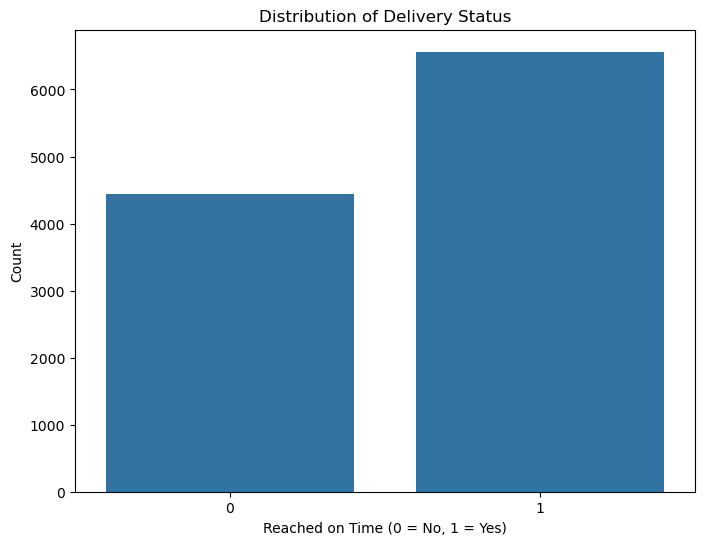

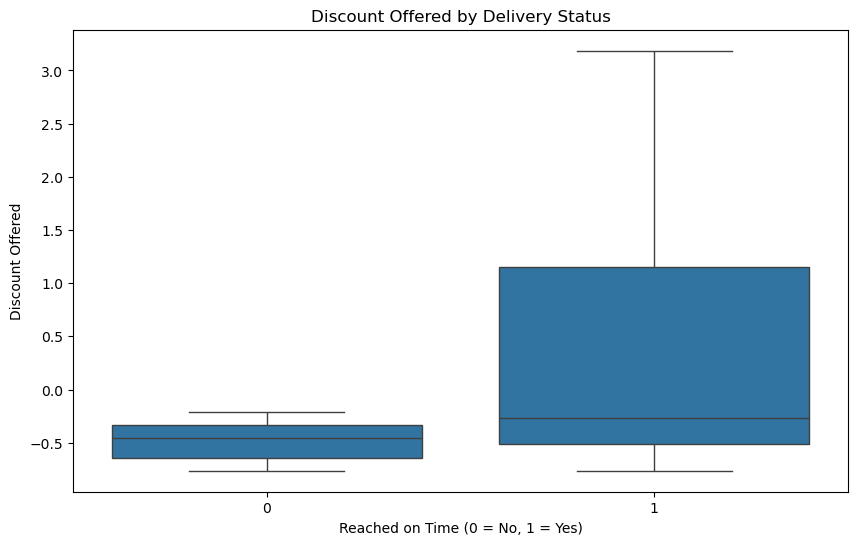

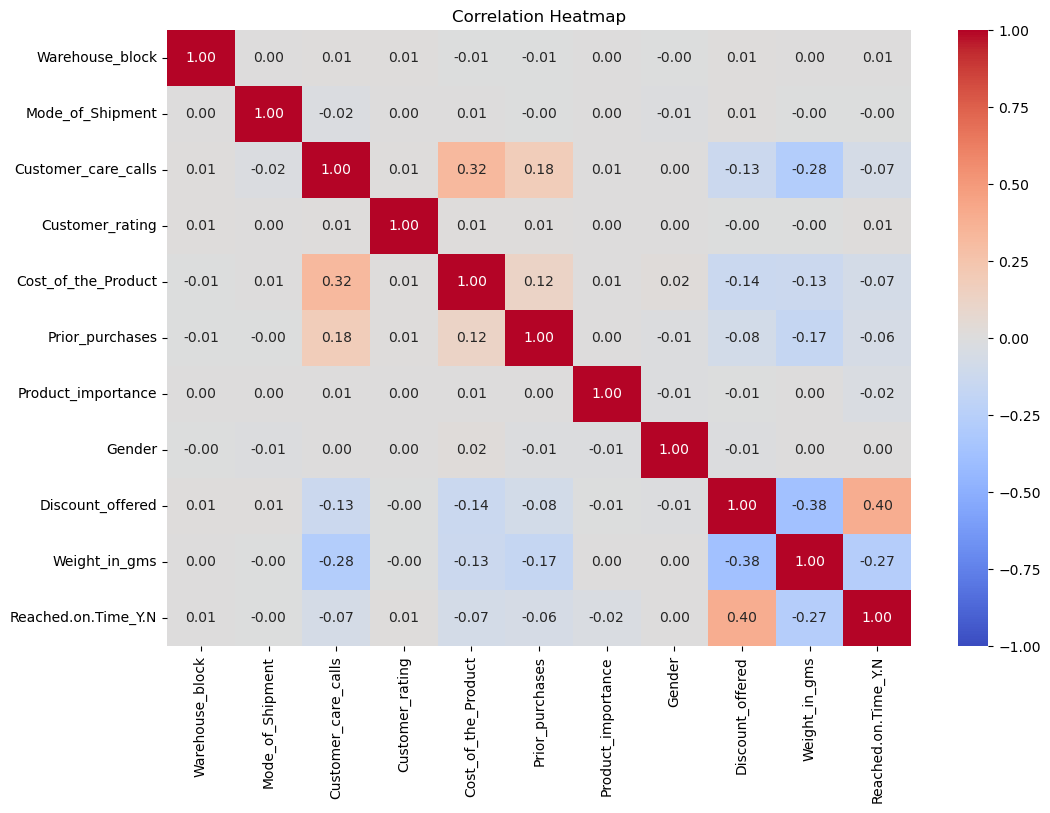

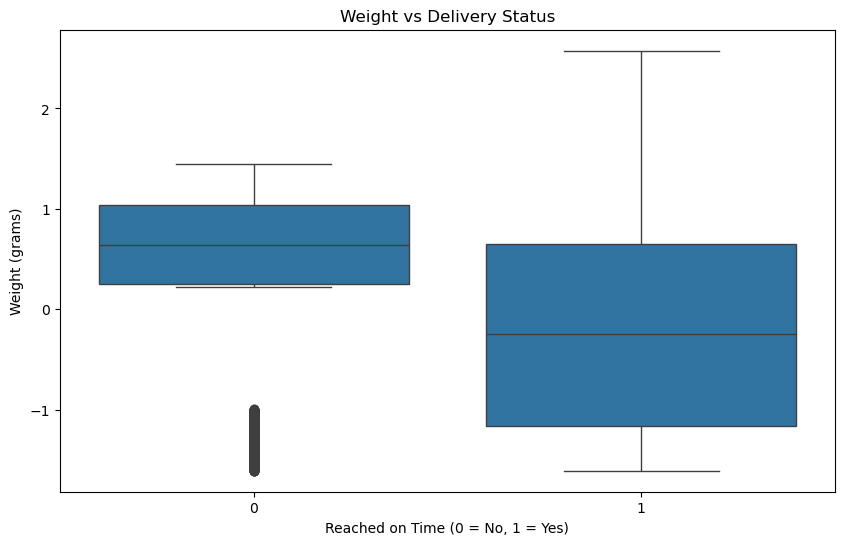

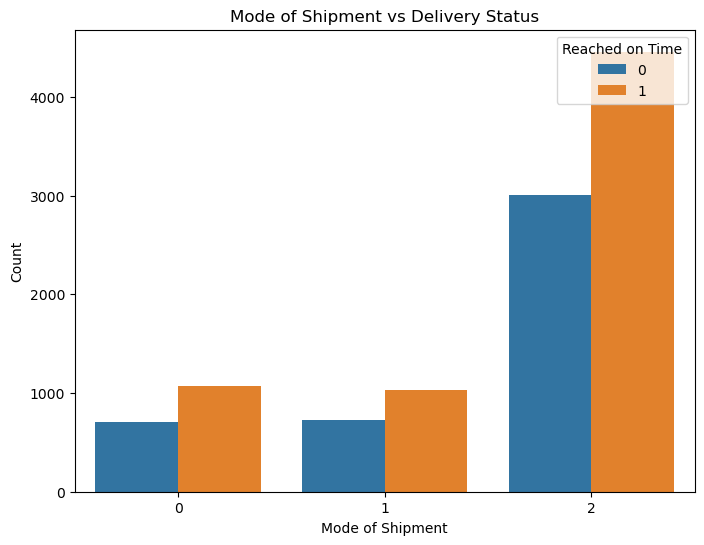

In [4]:
# Exploratory Data Analysis (EDA)
def visualize_data(df):
    # Distribution of Target Variable
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Reached.on.Time_Y.N')
    plt.title('Distribution of Delivery Status')
    plt.xlabel('Reached on Time (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.show()

    # Boxplot for Discount Offered by Delivery Status
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Reached.on.Time_Y.N', y='Discount_offered')
    plt.title('Discount Offered by Delivery Status')
    plt.xlabel('Reached on Time (0 = No, 1 = Yes)')
    plt.ylabel('Discount Offered')
    plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(12, 8))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()

    # Boxplot for Weight by Delivery Status
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Reached.on.Time_Y.N', y='Weight_in_gms')
    plt.title('Weight vs Delivery Status')
    plt.xlabel('Reached on Time (0 = No, 1 = Yes)')
    plt.ylabel('Weight (grams)')
    plt.show()

    # Countplot for Mode of Shipment
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Mode_of_Shipment', hue='Reached.on.Time_Y.N')
    plt.title('Mode of Shipment vs Delivery Status')
    plt.xlabel('Mode of Shipment')
    plt.ylabel('Count')
    plt.legend(title='Reached on Time', loc='upper right')
    plt.show()

visualize_data(pd.concat([X, y.rename('Reached.on.Time_Y.N')], axis=1))

In [5]:
# Feature Engineering
def feature_engineering(df):
    """
    Perform feature engineering on the dataset:
    - One-hot encode categorical variables.
    - Create new interaction features if applicable.
    
    Parameters:
    - df: Original DataFrame.
    
    Returns:
    - df: Feature-engineered DataFrame.
    """
    # One-hot encoding for categorical variables
    categorical_columns = ['Mode_of_Shipment', 'Warehouse_block', 'Product_importance']
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    return df

# Apply feature engineering
X = feature_engineering(X)
print("\nFeature-Engineered Data Overview:")
print(X.info())
print("\nFirst 5 Rows of Feature-Engineered Data:")
print(X.head())


Feature-Engineered Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_care_calls   10999 non-null  int64  
 1   Customer_rating       10999 non-null  int64  
 2   Cost_of_the_Product   10999 non-null  float64
 3   Prior_purchases       10999 non-null  int64  
 4   Gender                10999 non-null  int32  
 5   Discount_offered      10999 non-null  float64
 6   Weight_in_gms         10999 non-null  float64
 7   Mode_of_Shipment_1    10999 non-null  bool   
 8   Mode_of_Shipment_2    10999 non-null  bool   
 9   Warehouse_block_1     10999 non-null  bool   
 10  Warehouse_block_2     10999 non-null  bool   
 11  Warehouse_block_3     10999 non-null  bool   
 12  Warehouse_block_4     10999 non-null  bool   
 13  Product_importance_1  10999 non-null  bool   
 14  Product_importance_2  10999 non-nul

In [6]:
# Train-Test Split

# Define target and features
target = 'Reached.on.Time_Y.N'
features = [col for col in data.columns if col != target]

X = data[features]
y = data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nTraining Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (8799, 11)
Testing Data Shape: (2200, 11)


In [7]:
# Model Training

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, 'on_time_delivery_model.pkl')

print("Model training complete. Model saved as 'on_time_delivery_model.pkl'.")

Model training complete. Model saved as 'on_time_delivery_model.pkl'.


Accuracy: 0.67
Precision: 0.79
Recall: 0.61
F1-Score: 0.69
ROC-AUC: 0.74


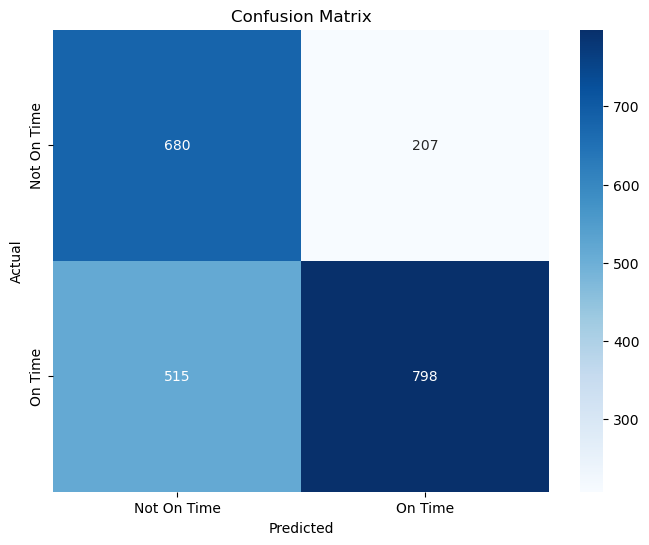


Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.77      0.65       887
           1       0.79      0.61      0.69      1313

    accuracy                           0.67      2200
   macro avg       0.68      0.69      0.67      2200
weighted avg       0.70      0.67      0.67      2200



In [8]:
# Model Evaluation

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

    # Classification Metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not On Time', 'On Time'], yticklabels=['Not On Time', 'On Time'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

evaluate_model(model, X_test, y_test)


In [10]:
# Real-Time Predictions

def predict_on_time_delivery(model, new_data, X_train, scaler=None):
    """
    Predict whether an order will be delivered on time.

    Parameters:
    - model: Trained classification model.
    - new_data: DataFrame containing features for the new order(s).
    - X_train: Training feature set to align columns.
    - scaler: Scaler object used during training (optional, if scaling was applied).

    Returns:
    - predictions: Predicted classes (0 = Not On Time, 1 = On Time).
    """
    # Align new data with the training data columns
    new_data_aligned = new_data.reindex(columns=X_train.columns, fill_value=0)

    # Apply scaling if a scaler was used
    if scaler:
        new_data_scaled = scaler.transform(new_data_aligned)
        predictions = model.predict(new_data_scaled)
    else:
        predictions = model.predict(new_data_aligned)

    return predictions

# Example new data with raw input
new_order = pd.DataFrame({
    'Customer_care_calls': [3],
    'Customer_rating': [4],
    'Cost_of_the_Product': [200],
    'Prior_purchases': [2],
    'Gender': [1],  # Assuming 1 = Male
    'Discount_offered': [10],
    'Weight_in_gms': [1200],
    'Mode_of_Shipment_1': [1],
    'Mode_of_Shipment_2': [0],
    'Warehouse_block_1': [0],
    'Warehouse_block_2': [1],
    'Warehouse_block_3': [0],
    'Warehouse_block_4': [0],
    'Product_importance_1': [1],
    'Product_importance_2': [0]
})

# Make prediction
predicted_class = predict_on_time_delivery(model, new_order, X_train)
status = "On Time" if predicted_class[0] == 1 else "Not On Time"
print(f"Predicted Delivery Status: {status}")

Predicted Delivery Status: On Time
